Create a sentiment analyzer from scratch.

Our roadmap: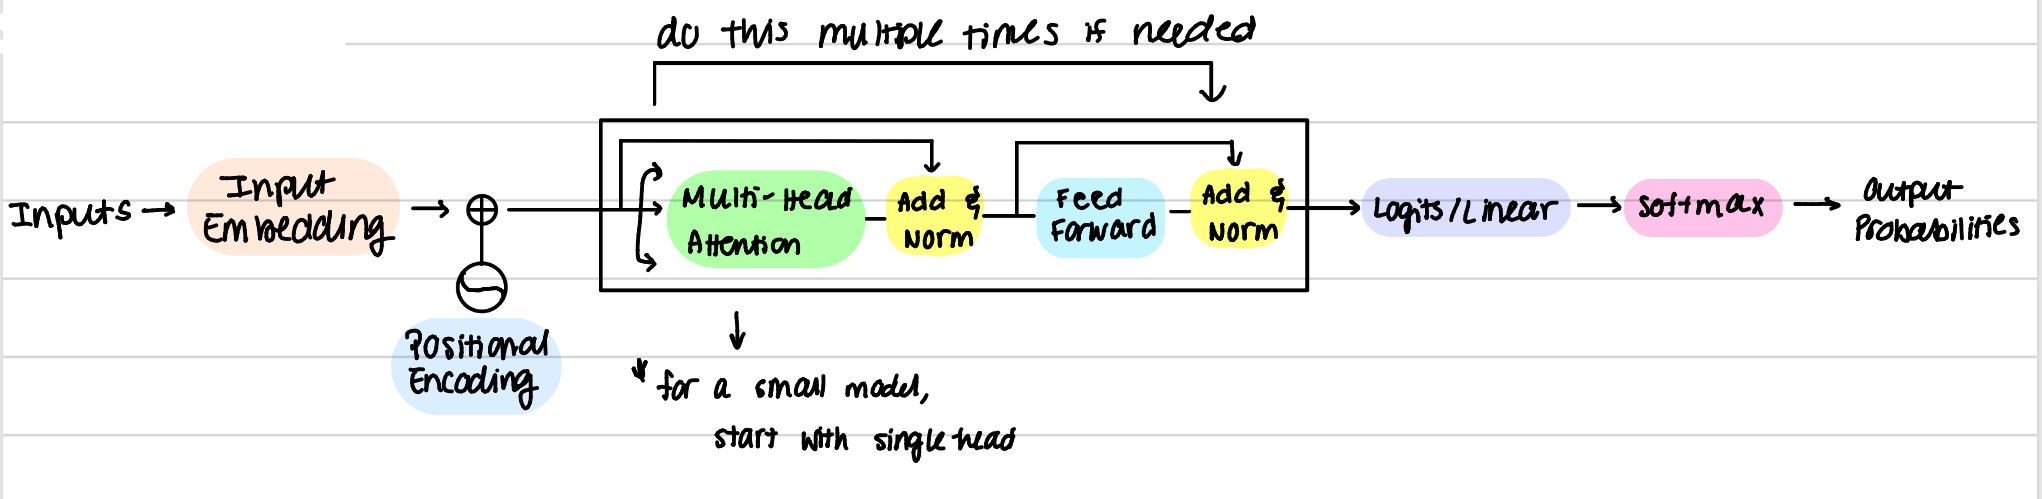

# **1. Dataset Preprocessing**

## **1A. Load Dataset**

In [1]:
!pip install kagglehub[pandas-datasets]

In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load the latest version using ISO-8859-1 encoding
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "nursyahrina/chat-sentiment-dataset",
    "chat_dataset.csv",
    pandas_kwargs={"encoding": "ISO-8859-1"}
)

print("df shape:", df.shape)

/tmp/ipython-input-2189190178.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 28.1k/28.1k [00:00<00:00, 32.5MB/s]

df shape: (584, 2)


In [3]:
df.head()

,message,sentiment
0,I really enjoyed the movie,positive
1,The food was terrible,negative
2,I'm not sure how I feel about this,neutral
3,The service was excellent,positive
4,I had a bad experience,negative


## **1B. Train-Test Split**

In [4]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

split_idx = int(0.8 * len(df_shuffled)) # 80% train 20% test
train = df_shuffled[:split_idx]
test = df_shuffled[split_idx:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (467, 2)
Test shape: (117, 2)


## **1C. Identify Balance**

In [5]:
import matplotlib.pyplot as plt

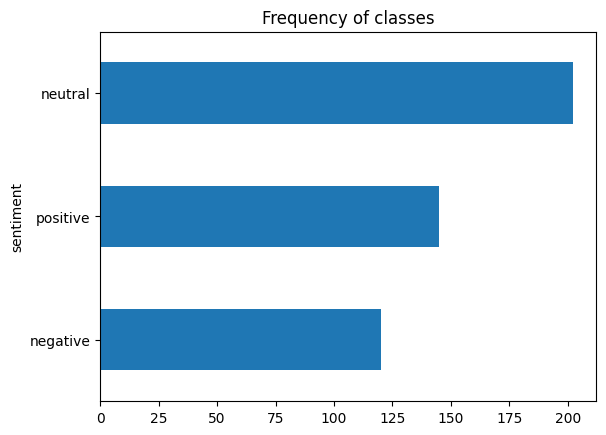

In [6]:
train['sentiment'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

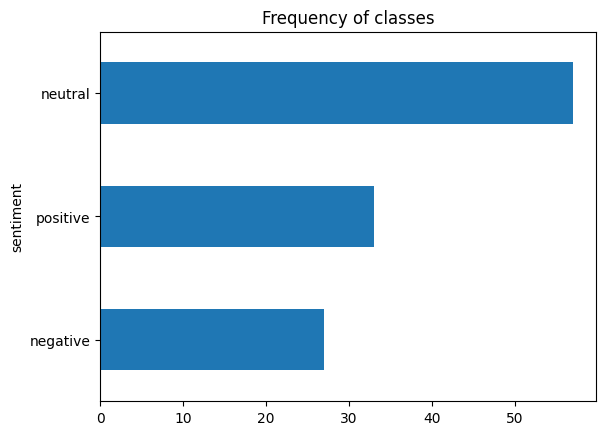

In [7]:
test['sentiment'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

In [8]:
import pandas as pd

In [9]:
# drop 50 rows with "neutral"

train_np = train[(train['sentiment'] == 'negative') | (train['sentiment'] == 'positive')]
train_ne = train[train['sentiment'] == 'neutral']
train_ne = train_ne.iloc[:-50]
train = pd.concat([train_np, train_ne], ignore_index=True, axis=0)

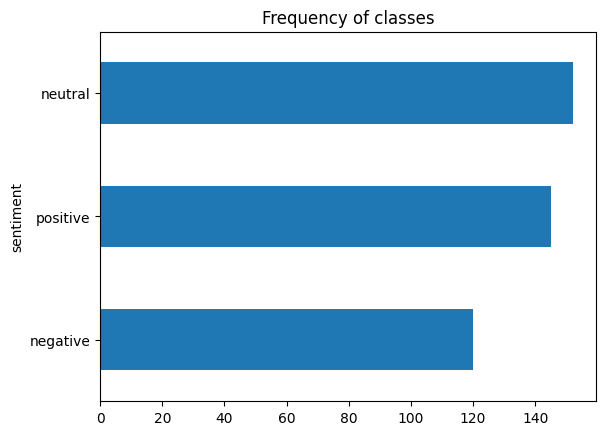

In [10]:
# test again

train['sentiment'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

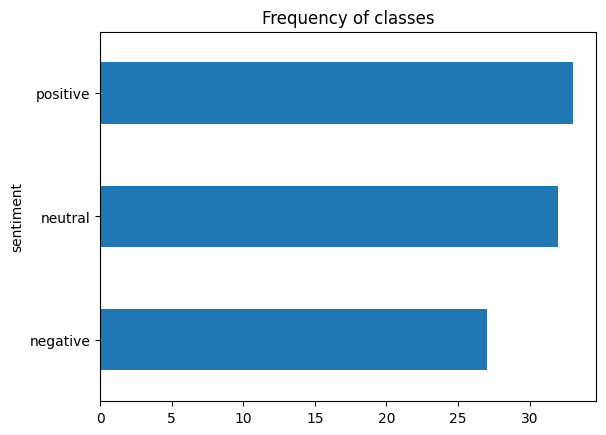

In [11]:
# same with test but drop 25

test_np = test[(test['sentiment'] == 'negative') | (test['sentiment'] == 'positive')]
test_ne = test[test['sentiment'] == 'neutral']
test_ne = test_ne.iloc[:-25]
test = pd.concat([test_np, test_ne], ignore_index=True, axis=0)

test['sentiment'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

## **1D. Look at words per tweet**

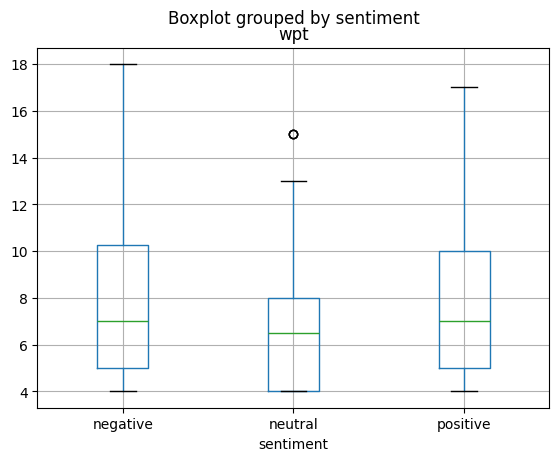

In [12]:
train.dropna(inplace=True)
train['wpt'] = train['message'].str.split().apply(len)
train.boxplot("wpt", by="sentiment")
plt.show()

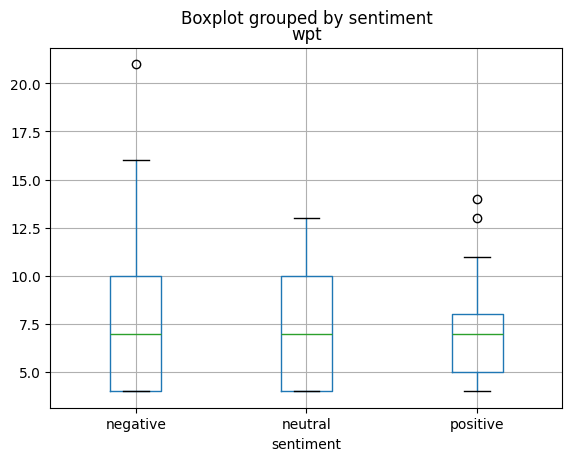

In [13]:
test.dropna(inplace=True)
test['wpt'] = test['message'].str.split().apply(len)
test.boxplot("wpt", by="sentiment")
plt.show()

Conclusion: no need to truncate since the maximum number of words per tweet is ~16-18, which is relatively low.

## **1E. Tokenizing and Lemmatizing**

For the sake of efficiency, we will use NLTK's `WordNetLemmatizer`.

In [14]:
from nltk import WordNetLemmatizer
import re

In [15]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [16]:
lemmatizer = WordNetLemmatizer()

In [17]:
word2idx = {'<PAD>': 0, '<UNK>': 1}

In [18]:
idx = 2

In [19]:
def tokenize(text):
  text = re.sub(r"http\\S+|www\\S+", "", text)
  text = re.sub(r"@[\\w_]+", "", text)
  text = re.sub(r"#(\\w+)", r"\\1", text)
  text = re.sub(r"[^a-z0-9\\s]", " ", text)
  text = re.sub(r"\s+", " ", text)

  tokens = text.split()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]
  return tokens

In [20]:
all_tokens = []
for i, row in train.iterrows():
  text = str(row['message']).lower()
  tokens = tokenize(text)

  all_tokens.extend(tokens)

In [21]:
from collections import Counter

counts = Counter(all_tokens)
most_common = counts.most_common(8000) # 8000 most frequent words

for i, (token, _) in enumerate(most_common, start=2):
    word2idx[token] = i

In [22]:
len(word2idx)

587

# **2. Create Embeddings**

## **2A. Embedding Matrix**

In [23]:
dim = 128 #dimension of embeddings
vocab_size = len(word2idx)

In [24]:
import numpy as np

In [25]:
embedding_matrix = np.random.normal(0, 0.01, size=(vocab_size, dim))

In [26]:
def generate_embeddings(text):
  tokens = tokenize(text)
  indices = [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]
  embeddings = []

  for index in indices:
    embeddings.append(embedding_matrix[index])

  return np.array(embeddings)

In [27]:
# e.g. convert a sentence to an embedding

sample_sentence = str(train.iloc[np.random.randint(0, train.shape[0])]['message'])
embedding = generate_embeddings(sample_sentence)
print(embedding)

[[ 3.62078327e-03  2.27561225e-02 -2.19242101e-03 -5.36825941e-03
  -4.22515558e-03 -1.61086989e-03  6.15611596e-03  1.47802293e-02
  -1.03408524e-02 -8.65308528e-03 -4.66027172e-03 -1.04637157e-02
   6.03183376e-04  5.67636309e-03  2.76167270e-03  3.93530804e-03
  -2.29065515e-03 -1.28595667e-02 -4.88141347e-03 -1.14129096e-03
   3.26938253e-03  1.53735311e-02  1.19233838e-03 -1.42827583e-02
  -8.78806437e-05  1.38799697e-02  3.70819228e-03  8.64521756e-03
   1.02420669e-02  9.63802680e-03 -1.99088701e-02  3.07544159e-03
  -1.68572219e-03  3.49954277e-03 -1.13323349e-02 -3.10795083e-04
   1.61692616e-03 -4.97612040e-03  1.20198830e-02 -8.32038166e-03
   4.57482293e-03 -1.50205135e-02  4.28516399e-03  9.33792326e-03
   1.18476270e-03 -3.82608681e-03 -8.52120440e-03  3.54250907e-03
  -2.15873352e-02  4.32643431e-03  2.94831913e-03  6.86994586e-03
  -1.17199018e-03 -1.78293011e-04 -4.02049504e-03 -1.16531066e-02
   4.41406226e-03  6.85708763e-03 -6.96074165e-03 -1.29236472e-02
   1.88029

## **2B. Analyze `<UNK>` Token Frequency**

Since we truncated the vocab size down to 8000, the remaining vocab would be naturally replaced with `<UNK>`. See how frequent those tokens are to see if we must extend the vocab or drop some rows.

In [28]:
def count_unk_tokens(text):
    tokens = tokenize(text)
    indices = [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]
    return indices.count(word2idx["<UNK>"])

In [29]:
train['unk_count'] = train['message'].apply(count_unk_tokens)

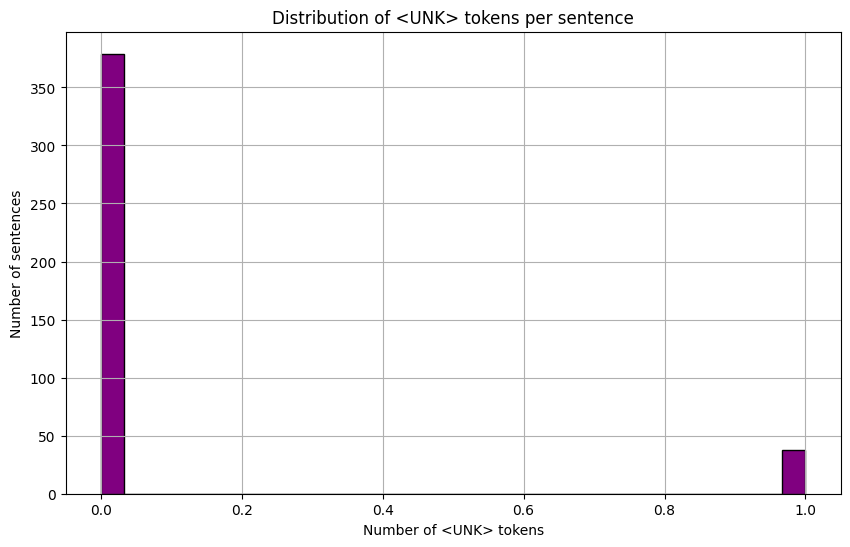

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(train['unk_count'], bins=30, color='purple', edgecolor='black')
plt.title("Distribution of <UNK> tokens per sentence")
plt.xlabel("Number of <UNK> tokens")
plt.ylabel("Number of sentences")
plt.grid(True)
plt.show()

## **2C. Analayze Non-tokenizable Texts**

In [31]:
def is_valid(text):
    tokens = tokenize(text)
    return len(tokens) > 0 and sum(1 for t in tokens if t not in word2idx) < len(tokens)

invalid = []
for idx, row in train.iterrows():
  text = row['message']
  if not is_valid(text):
    invalid.append(idx)

print(len(invalid))

0


All rows are tokenizable.

# **3. Positional Encoding**

$$
\text{PE}_{(\text{pos},\, 2i)} = \sin\left(\frac{\text{pos}}{10000^{\frac{2i}{d}}}\right)
$$
$$
\text{PE}_{(\text{pos},\, 2i+1)} = \cos\left(\frac{\text{pos}}{10000^{\frac{2i}{d}}}\right)
$$

In [32]:
def positional_encode(embeddings, dim=dim): #input an embedded sentence
  for pos, embedding in enumerate(embeddings):
    for i, _ in enumerate(embedding):
      exp = (2 * i) / dim
      den = 10000 ** exp
      val = pos / den
      if i % 2 == 0:
        embedding[i] += np.sin(val)
      else:
        embedding[i] += np.cos(val)
    embeddings[pos] = embedding

  return embeddings

# **4. Transformer Architecture**

## **4A. Multi-head Attention**

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{d_k}} \right) V
$$

In [33]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

In [34]:
def multi_head_attention(X, W_q_heads, W_k_heads, W_v_heads, W_o): #input an embedded sentence
  outputs = []
  A_list = []
  Q_list = []
  K_list = []
  V_list = []

  for idx, (W_q, W_k, W_v), in enumerate(zip(W_q_heads, W_k_heads, W_v_heads)):
    Q = X @ W_q
    K = X @ W_k
    V = X @ W_v

    scores = Q @ K.T
    head_dim = Q.shape[-1]
    scores_scaled = scores / np.sqrt(head_dim)
    # scores_scaled = np.clip(scores_scaled, -10, 10)
    A = softmax(scores_scaled)

    # print(f"[Head {idx}]")
    # print(f"scores mean: {scores.mean():.4f} | std: {scores.std():.4f} | max: {scores.max():.4f} | min: {scores.min():.4f}")
    # print(f"A mean: {A.mean():.6f} | std: {A.std():.6f} | max: {A.max():.6f}")

    output = A @ V

    outputs.append(output)
    A_list.append(A)
    Q_list.append(Q)
    K_list.append(K)
    V_list.append(V)

  concat = np.concatenate(outputs, axis=-1)

  out = concat @ W_o

  return out, A_list, Q_list, K_list, V_list

## **4B. Add + Layernorm**

In [35]:
def add_substep(X, substep):
  return X + substep

$$
\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$

In [36]:
def LayerNorm(X, gamma, beta, eps=1e-5):
  mean = X.mean(axis=1, keepdims=True)
  var = X.var(axis=1, keepdims=True)
  norm = (X - mean) / np.sqrt(var + eps)
  output = gamma * norm + beta

  return output

## **4C. Feed-Forward Network**

$$
\text{FFN}(x) = \text{ReLU}(xW_1 + b_1) W_2 + b_2
$$

In [37]:
def relu(x):
  return np.maximum(0, x)

In [38]:
def ffn(X, W_1, W_2, b_1, b_2):
  h1 = X @ W_1 + b_1
  a1 = relu(h1)

  output = a1 @ W_2 + b_2

  return output, a1, h1

## **4D. Transformer Block Class**

In [39]:
class TransformerBlock:
  def __init__(self, id, dim, num_heads):
    self.cached = {}
    self.id = id
    self.dim = dim
    self.num_heads = num_heads
    self.init_weights()

  def init_weights(self):
    head_dim = dim // self.num_heads
    d_ff = dim * 4

    self.cached = {
        "W_q_heads": [np.random.normal(0, 0.5, size=(dim, head_dim)) for _ in range(num_heads)],
        "W_k_heads": [np.random.normal(0, 0.5, size=(dim, head_dim)) for _ in range(num_heads)],
        "W_v_heads": [np.random.normal(0, 0.5, size=(dim, head_dim)) for _ in range(num_heads)],
        "W_o": np.random.normal(0, 0.5, size=(dim, dim)),

        "gamma1": np.ones(dim),
        "beta1": np.zeros(dim),

        "W_1": np.random.normal(0, np.sqrt(2 / (dim + d_ff)), size=(dim, d_ff)),
        "b_1": np.zeros(d_ff),
        "W_2": np.random.normal(0, np.sqrt(2 / (dim + d_ff)), size=(d_ff, dim)),
        "b_2": np.zeros(dim),

        "gamma2": np.ones(dim),
        "beta2": np.zeros(dim),
    }

  def forward(self, X):
    cached = self.cached

    cached['x'] = np.array(X)

    attn, A_list, Q_list, K_list, V_list = multi_head_attention(X, W_q_heads=cached['W_q_heads'],
                                          W_k_heads=cached['W_k_heads'], W_v_heads=cached['W_v_heads'],
                                          W_o=cached['W_o'])

    cached['attn'] = attn
    cached['A_list'] = A_list
    cached['Q_list'] = Q_list
    cached['K_list'] = K_list
    cached['V_list'] = V_list

    attn_norm = LayerNorm(attn, gamma=np.ones_like(attn[0]), beta=np.zeros_like(attn[0]))
    cached['attn_norm'] = attn_norm
    res1 = add_substep(X, attn_norm)
    cached['res1'] = res1

    ln1 = LayerNorm(res1, gamma=cached['gamma1'], beta=cached['beta1'])
    cached['ln1'] = ln1

    ffn_out, a1, h1 = ffn(ln1, W_1=cached['W_1'], W_2=cached['W_2'], b_1=cached['b_1'], b_2=cached['b_2'])
    cached['ffn_out'] = ffn_out
    cached['a1'] = a1
    cached['h1'] = h1

    res2 = add_substep(ln1, ffn_out)
    cached['res2'] = res2

    gamma2 = cached['gamma2']
    beta2 = cached['beta2']
    ln2 = LayerNorm(res2, gamma=cached['gamma2'], beta=cached['beta2'])
    cached['ln2'] = ln2

    return ln2

  def backward(self, grad_out, learning_rate):
    cached = self.cached
    dim = grad_out.shape[1]
    head_dim = self.head_dim

    grad_res2, grad_gamma2, grad_beta2 = layernorm_backward(grad_out, cached['res2'], cached['gamma2'], cached['beta2'])
    cached['gamma2'] -= learning_rate * grad_gamma2
    cached['beta2'] -= learning_rate * grad_beta2

    grad_ffn_out = grad_res2.copy()
    a1 = cached['a1']
    h1 = cached['h1']

    W_2 = cached['W_2']
    grad_W_2 = a1.T @ grad_ffn_out
    grad_b_2 = grad_ffn_out.sum(axis=0)
    grad_a1 = grad_ffn_out @ W_2.T
    grad_h1 = grad_a1 * (h1 > 0)

    ln1 = cached['ln1']
    W_1 = cached['W_1']
    grad_W_1 = ln1.T @ grad_h1
    grad_b_1 = grad_h1.sum(axis=0)
    grad_ln1 = grad_h1 @ W_1.T

    cached['W_2'] -= learning_rate * grad_W_2
    cached['b_2'] -= learning_rate * grad_b_2
    cached['W_1'] -= learning_rate * grad_W_1
    cached['b_1'] -= learning_rate * grad_b_1

    grad_res1, grad_gamma1, grad_beta1 = layernorm_backward(grad_ln1, cached['res1'], cached['gamma1'], cached['beta1'])
    cached['gamma1'] -= learning_rate * grad_gamma1
    cached['beta1'] -= learning_rate * grad_beta1

    grad_context = grad_res1.copy()
    grad_heads = np.split(grad_context, self.num_heads, axis=1)


    grad_Q_total = np.zeros_like(cached['x'])
    grad_K_total = np.zeros_like(cached['x'])
    grad_V_total = np.zeros_like(cached['x'])

    grad_W_q_list = []
    grad_W_k_list = []
    grad_W_v_list = []

    for i in range(num_heads):
      A = cached['A_list'][i]
      Q = cached['Q_list'][i]
      K = cached['K_list'][i]
      V = cached['V_list'][i]
      W_q = cached['W_q_heads'][i]
      W_k = cached['W_k_heads'][i]
      W_v = cached['W_v_heads'][i]

      grad_out_i = grad_heads[i]

      grad_V = A.T @ grad_out_i
      # print(f"grad_V norm (head {i}):", np.linalg.norm(grad_V))
      grad_A = grad_out_i @ V.T
      grad_scores = softmax_backward(grad_A, A)

      scale = np.sqrt(head_dim)
      grad_Q = grad_scores @ K / scale
      grad_K = grad_scores.T @ Q / scale

      grad_W_q = cached['x'].T @ grad_Q
      grad_W_k = cached['x'].T @ grad_K
      grad_W_v = cached['x'].T @ grad_V

      cached['W_q_heads'][i] -= learning_rate * grad_W_q
      cached['W_k_heads'][i] -= learning_rate * grad_W_k
      cached['W_v_heads'][i] -= learning_rate * grad_W_v

      grad_Q_total += grad_Q @ W_q.T
      grad_K_total += grad_K @ W_k.T
      grad_V_total += grad_V @ W_v.T

      grad_W_q_list.append(grad_W_q.copy())
      grad_W_k_list.append(grad_W_k.copy())
      grad_W_v_list.append(grad_W_v.copy())

    grad_input = grad_Q_total + grad_K_total + grad_V_total
    cached['grad_W_q'] = grad_W_q_list
    cached['grad_W_k'] = grad_W_k_list
    cached['grad_W_v'] = grad_W_v_list
    cached['grad_W_1'] = grad_W_1.copy()
    cached['grad_W_2'] = grad_W_2.copy()
    cached['grad_b_1'] = grad_b_1.copy()
    cached['grad_b_2'] = grad_b_2.copy()
    cached['grad_gamma1'] = grad_gamma1.copy()
    cached['grad_beta1'] = grad_beta1.copy()
    cached['grad_gamma2'] = grad_gamma2.copy()
    cached['grad_beta2'] = grad_beta2.copy()

    return grad_input

# **5. Classification Head Class**

In [40]:
class ClassifierHead:
  def __init__(self, dim, num_classes=3):
    self.W_vocab = np.random.normal(0, np.sqrt(2 / dim), size=(dim, num_classes))
    self.b_vocab = np.zeros(num_classes)
    self.cached = {}

  def probabilities(self, X_cls):
    logits = X_cls @ self.W_vocab + self.b_vocab

    return softmax(logits), logits

# **6. Forward Pass**

In [41]:
label2idx = {'negative': 0, 'neutral': 1, 'positive': 2}

In [42]:
def forward(text, transformer_blocks, classifier_head):
  X = generate_embeddings(text)
  X = positional_encode(X)

  for block in transformer_blocks:
    X = block.forward(X)

  x_cls = X[0]
  probs, logits = classifier_head.probabilities(x_cls)

  classifier_head.cached['logits'] = logits
  classifier_head.cached['x_cls'] = x_cls
  classifier_head.cached['probs'] = probs

  print("Logits:", logits.round(2))
  print("Probs:", probs.round(2))

  return probs, logits

# **7. Backward Pass**

In [43]:
def cross_entropy_loss(probs, label, eps=0.1):
  return -np.log(probs[label])

In [44]:
def layernorm_backward(grad_output, X, gamma, beta, eps=1e-4):
    N, D = X.shape

    mean = X.mean(axis=1, keepdims=True)
    var = X.var(axis=1, keepdims=True)
    std = np.sqrt(var + eps)
    norm = (X - mean) / std

    grad_gamma = np.sum(grad_output * norm, axis=0)
    grad_beta = np.sum(grad_output, axis=0)

    dnorm = grad_output * gamma

    dvar = np.sum(dnorm * (X - mean) * -0.5 * std**-3, axis=1, keepdims=True)
    dmean = (np.sum(dnorm * -1 / std, axis=1, keepdims=True) + dvar * np.mean(-2 * (X - mean), axis=1, keepdims=True))

    grad_input = dnorm / std + dvar * 2 * (X - mean) / D + dmean / D

    return grad_input, grad_gamma, grad_beta

In [45]:
'''

def softmax_backward(grad_output, softmax_output):
    grad_input = np.zeros_like(grad_output)

    for i in range(len(grad_output)):
        s = softmax_output[i].reshape(-1, 1)
        jacobian = np.diagflat(s) - s @ s.T
        grad_input[i] = jacobian @ grad_output[i]

    return grad_input
'''

def softmax_backward(grad_output, softmax_output):
    return softmax_output * (grad_output - np.sum(grad_output * softmax_output, axis=-1, keepdims=True))

In [46]:
# gradient descent and backpropogation
def backward(text, label, transformer_blocks, classifier_head, embedding_matrix, learning_rate=1e-3):
  cached = classifier_head.cached
  probs = cached['probs']
  ground_truth = label2idx[label]
  loss = cross_entropy_loss(probs, ground_truth)
  grad_logits = cached['probs'].copy()
  grad_logits[ground_truth] -= 1

  x_cls = cached['x_cls']
  W_vocab = classifier_head.W_vocab
  grad_W_vocab = np.outer(x_cls, grad_logits)
  grad_x_cls = grad_logits @ W_vocab.T
  classifier_head.W_vocab -= learning_rate * grad_W_vocab

  classifier_head.b_vocab -= learning_rate * grad_logits
  classifier_head.cached['grad_b_vocab'] = grad_logits.copy()

  ln2 = transformer_blocks[-1].cached['ln2']
  grad_hidden = np.zeros_like(ln2)
  grad_hidden[0] = grad_x_cls


  for block in reversed(transformer_blocks):
    grad_hidden = block.backward(grad_hidden, learning_rate)


  input_ids = [word2idx.get(tok, word2idx["<UNK>"]) for tok in tokenize(text)]
  for i, idx in enumerate(input_ids):

    #print("Before:", embedding_matrix[idx][:5])
    embedding_matrix[idx] -= learning_rate * grad_hidden[i]
    #print("After:", embedding_matrix[idx][:5])
    norm = np.linalg.norm(grad_hidden[i])
    if norm > 1:
        grad_hidden[i] = grad_hidden[i] / norm
    embedding_matrix[idx] -= learning_rate * grad_hidden[i]
    #print("Embedding update norm:", np.linalg.norm(grad_hidden[i]))
    #print("Before:", embedding_matrix[idx][:5])
    embedding_matrix[idx] -= learning_rate * grad_hidden[i]
    #print("After:", embedding_matrix[idx][:5])

  classifier_head.cached['grad_W_vocab'] = grad_W_vocab.copy()
  classifier_head.cached['grad_logits'] = grad_logits.copy()

  print("Grad norm embedding:", np.linalg.norm(grad_hidden))
  print("Grad norm W_vocab:", np.linalg.norm(classifier_head.cached['grad_W_vocab']))

  return loss

# **8. Training Start**

## **8A. Initialize Classes**

In [47]:
num_heads = 4
head_dim = dim // num_heads

transformer_blocks = [
    TransformerBlock(id=1, dim=dim, num_heads=4), # transformer1
    TransformerBlock(id=2, dim=dim, num_heads=4) #transformer2
]

classifier_head = ClassifierHead(dim=dim)

## **8B. Training Loop**

In [48]:
train_data = (list(zip(train['message'], train['sentiment'])))

In [49]:
'''
positive_samples = train[train['sentiment'] == 'positive'].sample(n=15, random_state=42)
neutral_samples = train[train['sentiment'] == 'neutral'].sample(n=15, random_state=42)
negative_samples = train[train['sentiment'] == 'negative'].sample(n=15, random_state=42)

balanced_df = pd.concat([positive_samples, neutral_samples, negative_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

train_data = list(zip(balanced_df['message'], balanced_df['sentiment']))
'''

"\npositive_samples = train[train['sentiment'] == 'positive'].sample(n=15, random_state=42)\nneutral_samples = train[train['sentiment'] == 'neutral'].sample(n=15, random_state=42)\nnegative_samples = train[train['sentiment'] == 'negative'].sample(n=15, random_state=42)\n\nbalanced_df = pd.concat([positive_samples, neutral_samples, negative_samples]).sample(frac=1, random_state=42).reset_index(drop=True)\n\ntrain_data = list(zip(balanced_df['message'], balanced_df['sentiment']))\n"

In [50]:
def entropy(A):
    return -np.sum(A * np.log(A + 1e-9)) / A.shape[0]

In [51]:
def print_grads(transformer_blocks, classifier_head):
    print("=== Classifier Head Gradients ===")
    if 'grad_W_vocab' in classifier_head.cached:
        print("W_vocab grad norm:", np.linalg.norm(classifier_head.cached['grad_W_vocab']))
    else:
        print("W_vocab gradients not found.")

    for block in transformer_blocks:
        print(f"\n=== Transformer Block {block.id} Gradients ===")
        cached = block.cached

        if 'grad_W_q' in cached:
            for i, grad in enumerate(cached['grad_W_q']):
                print(f"Head {i} W_q grad norm:", np.linalg.norm(grad))
        if 'grad_W_k' in cached:
            for i, grad in enumerate(cached['grad_W_k']):
                print(f"Head {i} W_k grad norm:", np.linalg.norm(grad))
        if 'grad_W_v' in cached:
            for i, grad in enumerate(cached['grad_W_v']):
                print(f"Head {i} W_v grad norm:", np.linalg.norm(grad))

        for key in ['grad_W_1', 'grad_b_1', 'grad_W_2', 'grad_b_2', 'grad_gamma1', 'grad_beta1', 'grad_gamma2', 'grad_beta2']:
            if key in cached:
                print(f"{key} norm:", np.linalg.norm(cached[key]))
            else:
                print(f"{key} not found.")

In [52]:
import random

def train_model(data, embedding_matrix, transformer_blocks, classifier_head, epochs=100, batch_size=32, learning_rate=1e-3):
    losses = []

    for epoch in range(epochs):
        random.shuffle(data)
        batch_losses = []

        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            batch_loss = 0

            for text, label in batch:
                forward(text, transformer_blocks, classifier_head)
                loss = backward(text, label, transformer_blocks, classifier_head, embedding_matrix, learning_rate)
                batch_loss += loss

            avg_loss = batch_loss / len(batch)
            batch_losses.append(avg_loss)

            if (i // batch_size) % 10 == 0:
              print(f"Epoch {epoch+1}, Batch {i//batch_size}, Loss: {avg_loss:.4f}")
              print_grads(transformer_blocks, classifier_head)

        epoch_loss = np.sum(batch_losses)
        print(f"Total Epoch Loss for Epoch {epoch+1}: {epoch_loss:.4f}")
        losses.append(epoch_loss)

    return losses

In [53]:
losses = train_model(train_data, embedding_matrix, transformer_blocks, classifier_head)

Streaming output truncated to the last 5000 lines.
Grad norm embedding: 0.027374887633644512
Grad norm W_vocab: 0.002348078525793497
Logits: [-4.37 -2.57  7.59]
Probs: [0. 0. 1.]
Grad norm embedding: 0.023352149043780475
Grad norm W_vocab: 0.0006734782289054829
Logits: [-6.74  9.3  -1.46]
Probs: [0. 1. 0.]
Grad norm embedding: 0.0029530725614758894
Grad norm W_vocab: 0.00034210694894821906
Logits: [ 7.27 -0.62 -4.99]
Probs: [1. 0. 0.]
Grad norm embedding: 0.09981421148340738
Grad norm W_vocab: 0.0060999451618124504
Logits: [-6.    9.07 -2.21]
Probs: [0. 1. 0.]
Grad norm embedding: 0.0015076795604908805
Grad norm W_vocab: 0.00020382279757520888
Logits: [ 5.46 -3.34 -2.27]
Probs: [1. 0. 0.]
Grad norm embedding: 0.07869598803753114
Grad norm W_vocab: 0.008566275214401457
Logits: [ 6.58 -2.87 -2.46]
Probs: [1. 0. 0.]
Grad norm embedding: 0.034039767726086946
Grad norm W_vocab: 0.0027729026799995916
Logits: [ 5.66 -3.05 -2.1 ]
Probs: [1. 0. 0.]
Grad norm embedding: 0.07616994349154368
Grad 

In [54]:
train['sentiment'][:50].value_counts()

,count
sentiment,
positive,28
negative,22


## **8C. Plot Losses**

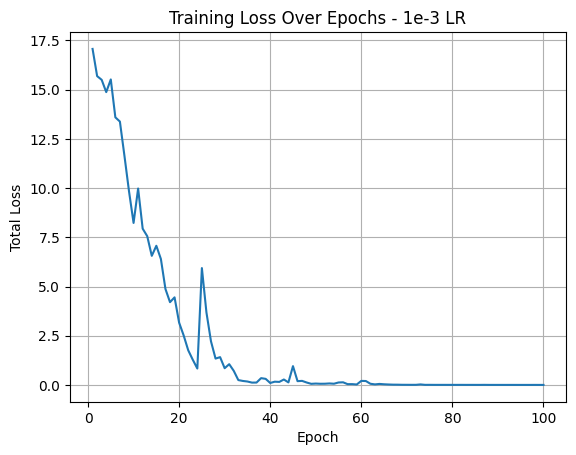

In [55]:
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training Loss Over Epochs - 1e-3 LR")
plt.grid(True)
plt.show()

# **9. Testing Loop**

In [56]:
idx2label = {0: "negative", 1: "neutral", 2: "positive"}

In [57]:
def predict(text, transformer_blocks, classifier_head):
  forward(text, transformer_blocks, classifier_head)
  probs = classifier_head.cached['probs']
  pred_idx = np.argmax(probs)
  return idx2label[pred_idx]

In [58]:
def test_model(test_data, transformer_blocks, classifier_head):
    correct = 0
    total = 0
    accuracies = []
    true_labels = []
    predicted_labels = []

    for i, (text, label) in enumerate(test_data):
        pred_label = predict(text, transformer_blocks, classifier_head)
        true_labels.append(label2idx[label])
        predicted_labels.append(label2idx[pred_label])

        if pred_label == label:
            correct += 1
        total += 1

        accuracy = correct / total
        accuracies.append(accuracy)

    return accuracies, true_labels, predicted_labels

In [59]:
test_data = (list(zip(test['message'], test['sentiment'])))

In [60]:
accuracies, true_labels, predicted_labels = test_model(test_data, transformer_blocks, classifier_head)

Logits: [-5.14 -2.34  7.4 ]
Probs: [0. 0. 1.]
Logits: [ 0.16 -3.57  4.14]
Probs: [0.02 0.   0.98]
Logits: [ 6.09 -4.58  0.11]
Probs: [1. 0. 0.]
Logits: [-3.38  4.18  0.2 ]
Probs: [0.   0.98 0.02]
Logits: [-3.88 -1.44  4.78]
Probs: [0. 0. 1.]
Logits: [-4.07 -3.27  6.99]
Probs: [0. 0. 1.]
Logits: [ 6.35 -2.83 -2.86]
Probs: [1. 0. 0.]
Logits: [-4.64  0.8   4.54]
Probs: [0.   0.02 0.98]
Logits: [ 2.1  -5.61  3.73]
Probs: [0.16 0.   0.84]
Logits: [-6.58  3.3   4.4 ]
Probs: [0.   0.25 0.75]
Logits: [-5.93 -0.21  7.1 ]
Probs: [0. 0. 1.]
Logits: [-0.01 -3.81  2.98]
Probs: [0.05 0.   0.95]
Logits: [ 6.31 -5.43 -1.99]
Probs: [1. 0. 0.]
Logits: [ 7.08 -2.98 -3.34]
Probs: [1. 0. 0.]
Logits: [-3.77 -3.02  5.63]
Probs: [0. 0. 1.]
Logits: [ 4.59 -1.99 -1.77]
Probs: [1. 0. 0.]
Logits: [-0.09 -5.36  5.3 ]
Probs: [0. 0. 1.]
Logits: [-3.88 -1.87  5.63]
Probs: [0. 0. 1.]
Logits: [ 6.48 -1.06 -3.71]
Probs: [1. 0. 0.]
Logits: [-3.62  6.44 -2.14]
Probs: [0. 1. 0.]
Logits: [-1.75 -5.46  5.5 ]
Probs: [0. 0. 1.

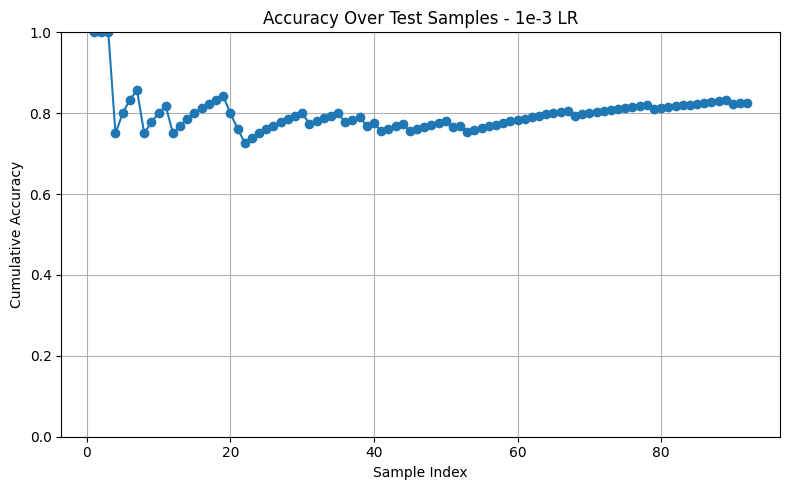

In [61]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.xlabel("Sample Index")
plt.ylabel("Cumulative Accuracy")
plt.title("Accuracy Over Test Samples - 1e-3 LR")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

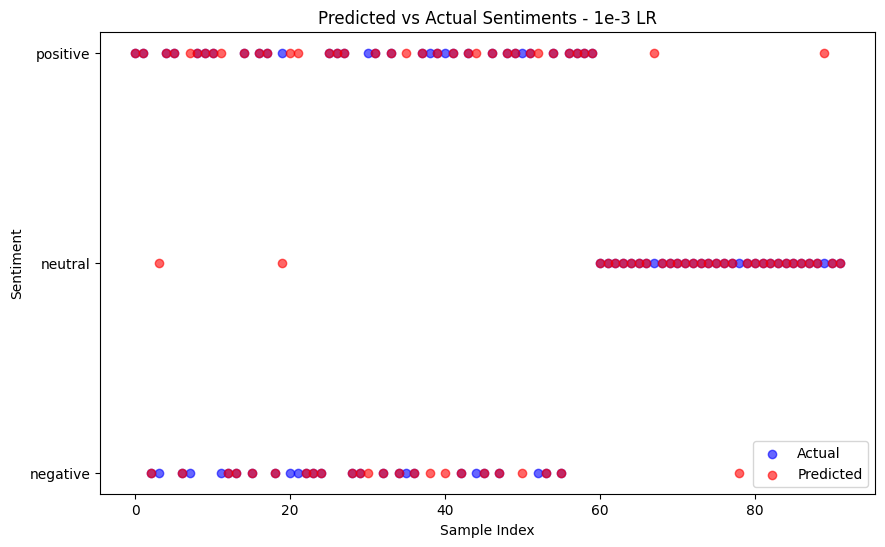

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(test_data)), true_labels, color='blue', label='Actual', alpha=0.6)
plt.scatter(range(len(test_data)), predicted_labels, color='red', label='Predicted', alpha=0.6)
plt.yticks([0, 1, 2], list(label2idx.keys()))
plt.xlabel("Sample Index")
plt.ylabel("Sentiment")
plt.title("Predicted vs Actual Sentiments - 1e-3 LR")
plt.legend()
plt.show()

In [63]:
np.mean(accuracies)

np.float64(0.7981017468475567)

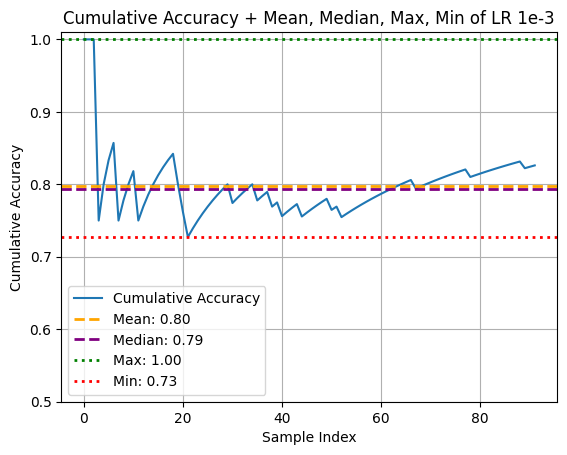

In [64]:
sample_indices = np.arange(len(accuracies))
plt.plot(sample_indices, accuracies, label="Cumulative Accuracy")

mean_acc = np.mean(accuracies)
median_acc = np.median(accuracies)
max_acc = np.max(accuracies)
min_acc = np.min(accuracies)

plt.axhline(mean_acc, color='orange', linestyle='--', linewidth=2, label=f"Mean: {mean_acc:.2f}")
plt.axhline(median_acc, color='purple', linestyle='--', linewidth=2, label=f"Median: {median_acc:.2f}")
plt.axhline(max_acc, color='green', linestyle=':', linewidth=2, label=f"Max: {max_acc:.2f}")
plt.axhline(min_acc, color='red', linestyle=':', linewidth=2, label=f"Min: {min_acc:.2f}")

plt.xlabel("Sample Index")
plt.ylabel("Cumulative Accuracy")
plt.title("Cumulative Accuracy + Mean, Median, Max, Min of LR 1e-3")
plt.ylim(0.5, 1.01)
plt.legend()
plt.grid(True)
plt.show()

# **10. Save Model Checkpoint**

This will be for saving model prototypes I think are good so far.

In [65]:
import pickle

with open("model_checkpoint_2.pkl", "wb") as f:
    pickle.dump({
        "embedding_matrix": embedding_matrix,
        "transformer_blocks": transformer_blocks,
        "classifier_head": classifier_head,
        "label2idx": label2idx,
        "idx2label": idx2label,
        "word2idx": word2idx
    }, f)

# **11. Final Model Structure**

This will be where I create a final class where I save final models.

In [66]:
class SimpleSentimentAnalyzer:
  def __init__(self, word2idx, embedding_matrix, transformer_blocks, classifier_head, label2idx, idx2label):
    self.dim = 128
    self.lemmatizer = WordNetLemmatizer()
    self.word2idx = word2idx
    self.embedding_matrix = embedding_matrix
    self.transformer_blocks = transformer_blocks
    self.classifier_head = classifier_head
    self.label2idx = label2idx
    self.idx2label = idx2label

  def tokenize(self, text):
    text = re.sub(r"http\\S+|www\\S+", "", text)
    text = re.sub(r"@[\\w_]+", "", text)
    text = re.sub(r"#(\\w+)", r"\\1", text)
    text = re.sub(r"[^a-z0-9\\s]", " ", text)
    text = re.sub(r"\s+", " ", text)

    tokens = text.split()
    tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
    return tokens

  def generate_embeddings(self, text):
    tokens = self.tokenize(text)
    indices = [self.word2idx.get(token, self.word2idx["<UNK>"]) for token in tokens]
    embeddings = []

    for index in indices:
      embeddings.append(self.embedding_matrix[index])

    return np.array(embeddings)

  def positional_encode(self, embeddings): #input an embedded sentence
    for pos, embedding in enumerate(embeddings):
      for i, _ in enumerate(embedding):
        exp = (2 * i) / self.dim
        den = 10000 ** exp
        val = pos / den
        if i % 2 == 0:
          embedding[i] += np.sin(val)
        else:
          embedding[i] += np.cos(val)
      embeddings[pos] = embedding

    return embeddings

  def softmax(self, x):
    x = x - np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

  def multi_head_attention(self, X, W_q_heads, W_k_heads, W_v_heads, W_o):
    outputs = []
    A_list = []
    Q_list = []
    K_list = []
    V_list = []

    for idx, (W_q, W_k, W_v), in enumerate(zip(W_q_heads, W_k_heads, W_v_heads)):
      Q = X @ W_q
      K = X @ W_k
      V = X @ W_v

      scores = Q @ K.T
      head_dim = Q.shape[-1]
      scores_scaled = scores / np.sqrt(head_dim)
      A = self.softmax(scores_scaled)

      output = A @ V

      outputs.append(output)
      A_list.append(A)
      Q_list.append(Q)
      K_list.append(K)
      V_list.append(V)

    concat = np.concatenate(outputs, axis=-1)

    out = concat @ W_o

    return out, A_list, Q_list, K_list, V_list

  def add_substep(self, X, substep):
    return X + substep

  def LayerNorm(self, X, gamma, beta, eps=1e-5):
    mean = X.mean(axis=1, keepdims=True)
    var = X.var(axis=1, keepdims=True)
    norm = (X - mean) / np.sqrt(var + eps)
    output = gamma * norm + beta

    return output

  def relu(self, x):
    return np.maximum(0, x)

  def ffn(self, X, W_1, W_2, b_1, b_2):
    h1 = X @ W_1 + b_1
    a1 = self.relu(h1)

    output = a1 @ W_2 + b_2

    return output, a1, h1

  def forward(self, text):
    X = self.generate_embeddings(text)
    X = self.positional_encode(X)

    for block in self.transformer_blocks:
      X = block.forward(X, self)

    x_cls = X[0]
    probs, logits = self.classifier_head.probabilities(x_cls)

    self.classifier_head.cached['logits'] = logits
    self.classifier_head.cached['x_cls'] = x_cls
    self.classifier_head.cached['probs'] = probs

    return probs, logits

  def predict(self, text):
    self.forward(text)
    probs = self.classifier_head.cached['probs']
    pred_idx = np.argmax(probs)
    return self.idx2label[pred_idx]

In [67]:
analyzer = SimpleSentimentAnalyzer(word2idx, embedding_matrix, transformer_blocks, classifier_head, label2idx, idx2label)
with open("sentiment_analyzer_1.pkl", "wb") as f:
    pickle.dump({
        "analyzer": analyzer
    }, f)

In [68]:
!pip freeze > requirements.txt

# **12. Try it Out**

In [69]:
text = "I hate you so much!"
prediction = predict(text, transformer_blocks, classifier_head)
prediction

Logits: [ 7.62 -4.43 -3.42]
Probs: [1. 0. 0.]


'negative'

# **13. Logs**

In [70]:
test.shape

(92, 3)

**Learning Rates + File:**

1e-3 -> sentiment_analyzer_1.pkl